# Financial Econometrics 2 - Project 2
## Matyáš Mattanelli & Jan Kubal

**Part A)**

*Old Assignment:*
Use same data as in Project 1, Estimate time varying OLS HAR. Find the kernel bandwidth minimizing out of smaple MSE, HAR horizons 1, 5, 22. 

---

## Project 2 - Instructions

**Details:** Students are encouraged to form a group of two for project 2 which will be assigned in three small parts during the semester. Evaluation of this project will be during the final exam, when students will present and discuss their results.

### Part A:
Construct the TV-HAR model with tvOLS (or with any other function). Find the kernel bandwidth minimizing the MSE for the out-of-sample forecast for horizons 1, 5, and 22.

### Part B:
Estimate time-varying volatility of stock price time series (or an index) using the Stochastic volatility model. You can take the specification from lecture notes (Lecture 9), or you can define your own. For this task, you can use R package "stochvol" or you can use any other tool for state space models.

Perform also an out-of-sample forecast (horizon 1, 5, 22) and compare the forecasting performance with a GARCH family model of your choice.

### Part C:
Construct the TV-HAR model using the QBLL estimator. Compare the out-of-sample forecast performance with models in **Part A** of Project 2.

### Final: Fusion of Project 1 and Project 2:
Compare the prediction performance of all TV models in this project with the best neural network model from Project 1.

## Environment preparation

In [1]:
#Activate the environment
import Pkg
Pkg.activate(".")
#Pkg.instantiate() #In case the environment is activated for the first time

  Activating project at `d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1`


In [107]:
#Load packages
import CSV
import DataFrames
import Plots
import Dates
import MarketData
import Statistics
import ARCHModels

import RCall
RCall.R"library(tvReg)"
RCall.R"library(stochvol)"
RCall.R"library(rugarch)"

#Load auxilliary functions
include("utils.jl")

[> Loaded d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1\utils.jl


## Part A

In the first part we construct the time-varying HAR model (tvHAR) using the R package ``tvReg``, more specifically the ``tvLM`` function which is used to fit time-varying parameters linear models. For this modl, we find the kernel bandwidth minimizing the MSE for the out-of-sample forecast for horizons 1, 5, and 22.

The underlying asset is VanEck Oil Services ETF (OIH), which is an ETF aiming to reflect the overall market performance of US oil industry-related firms. Five years (January 2012 to December 2017) of 1-minute intraday prices were acquired from [kibot.com](http://www.kibot.com/free_historical_data.aspx).

We start with loading the data, computing the daily Realized Variance and creating the variables for HAR model (lagged versions of RV)

In [108]:
#Load data
data_OIH = CSV.read("OIH_adjusted_cut.csv", DataFrames.DataFrame; header=false);
data_OIH[1:5, :] #Take a peak at the data

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,String15,Time,Float64,Float64,Float64,Float64,Int64
1,01/03/2012,07:31:00,668.19,668.19,668.19,668.19,18
2,01/03/2012,08:00:00,648.82,648.82,648.82,648.82,35
3,01/03/2012,08:08:00,659.61,659.61,659.61,659.61,18
4,01/03/2012,09:01:00,662.71,662.71,662.71,662.71,159
5,01/03/2012,09:02:00,662.71,662.71,662.71,662.71,177


In [109]:
#Calculate RV 
target = get_RV_from_kibot(data_OIH, returns_log = false)

#Compute HAR regressors
predictors = HAR_regressors(target)
predictors = Float64.(predictors)

#Shift the target
target = target[23:end]
target = Float64.(target);

Now that the data is ready, we define a function estimating a single tvHAR model based on a single horizon and bandwidth. The function returns the MSE on the testing sample. Note that we set the parameter ``est`` of ``tvLM`` to "ll" in order to perform local linear estimation.

In [110]:
#Function for tvHAR estimation
function get_tvLM_MSE(horizon, bandwith; predictors = predictors, target = target, kernel = "Triweight")
    #Separate the testing and training sample
    predictors_train = predictors[1:end-horizon, :] 
    predictors_test = predictors[end-horizon+1:end, :]
    target_train = target[1:end-horizon]
    target_test = target[end-horizon+1:end]
    #Estimate the model and forecast
    RCall.R""" 
    tv_ols <- tvLM($target_train ~ $(predictors_train[:, 1]) + $(predictors_train[:, 2]) + $(predictors_train[:, 3]), bw = $bandwith , est = 'll', tkernel = $kernel)
    preds <- forecast(tv_ols, $predictors_test, n.ahead = $horizon)
    """
    #print(tv_ols$coefficients) prints out the coefficients
    preds = RCall.convert(Array{Float64}, RCall.R"preds") #Convert the predictions from R to Julia
    MSE = Statistics.mean((preds .- target_test).^2) #Calculate the MSE
    return MSE
end;

In the next step we define a helper function that loops through multiple bandwiths, estimates a model for each and returns their out of sample MSE.

In [6]:
#Function for finding the optimal bandwidth for a specific horizon
function get_best_bw(min_bw, max_bw, step, horizon; predictors = predictors, target = target, kernel = "Triweight", verbose = false, plot_mses = true)
    bws = collect(range(min_bw, max_bw, step = step)) #Specify the range of bandwidths
    MSEs = zeros(length(bws)) #Empty array for the MSEs for each window
    for idx in 1:length(bws) #Loop through the bandwidths
        if verbose #Print info if required
            println("window $window_size out of $max_wind for horizon $horizon") 
        end
        MSEs[idx] = get_tvLM_MSE(horizon, bws[idx], predictors = predictors, target = target, kernel = kernel) #Get MSE for given iteration
    end
    if plot_mses #Plot the bandwidths agains the MSEs if required
        display(Plots.plot(bws, MSEs, legend = false, xlab = "Bandwidth", ylab = "MSE", title = "Horizon $horizon"))
    end
    return bws[argmin(MSEs)], minimum(MSEs) #Return the best bandwidth along with its MSE
end;


get_best_bw (generic function with 1 method)

Now we can search through a range of bandwiths and find the one minimizing the out of sample MSE for each horizon.

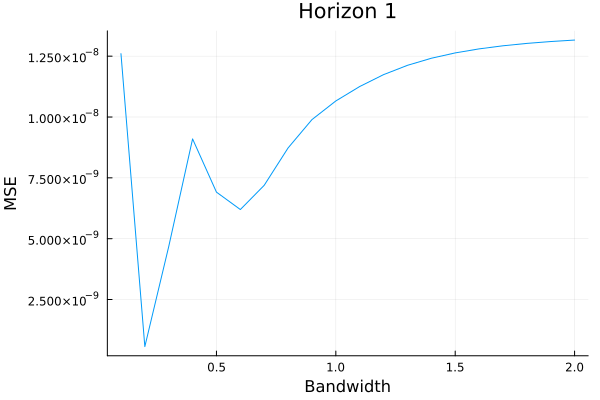

For horizon 1 found optimum window 0.2, MSE 5.650837574471458e-10


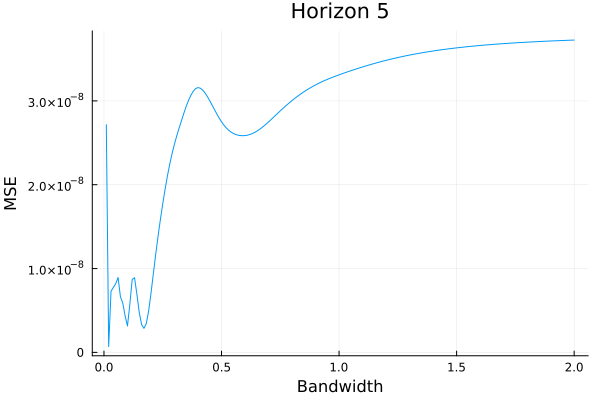

For horizon 5 found optimum window 0.02, MSE 6.905384921811106e-10


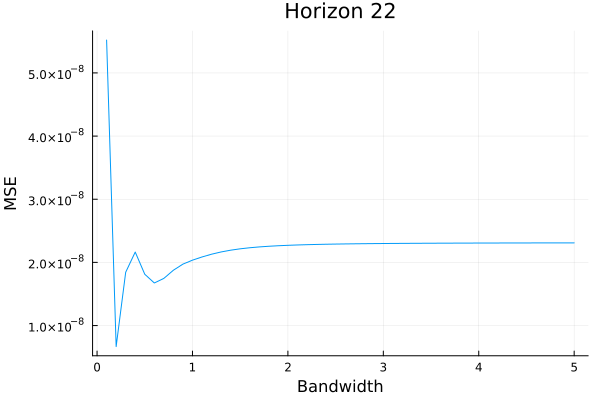

For horizon 22 found optimum window 0.2, MSE 6.668888245893575e-9


In [7]:
#runtime 5:50
#Horizon 1
optimum_hor_1 = get_best_bw(0.1, 2, 0.1, 1)
println("For horizon 1 found optimum window $(optimum_hor_1[1]), MSE $(optimum_hor_1[2])")
#Horizon 5
optimum_hor_5 = get_best_bw(0.01, 2, 0.01, 5)
println("For horizon 5 found optimum window $(optimum_hor_5[1]), MSE $(optimum_hor_5[2])")
#Horizon 22
optimum_hor_22 =  get_best_bw(0.1, 5, 0.1, 22)
println("For horizon 22 found optimum window $(optimum_hor_22[1]), MSE $(optimum_hor_22[2])")

As we can see, we find the minimum for all horizons. Horizons 1 and 22 share the same bandwidth of 0.2 while the optimal bandwidth for horizon 5 appears to be substantially smaller.

## Part B
In the second part of the project we estimate a Stochastic volatility model on the McDonald's stock price. We then compare the out of sample forecasts with a GARCH model.

We start by downloading the data from Yahoo Finance. We acquire only years worth of daily data (January 2012 - December 2021).

In [3]:
#Download data for McDonald's stock from Yahoo (42.2s)
t1 = Dates.DateTime(2012, 1, 1) #Starting period
t2 = Dates.DateTime(2022, 1, 1) #Ending period
MCD = MarketData.yahoo("MCD", MarketData.YahooOpt(period1 = t1, period2 = t2));

Next, we calculate the log-returns.

In [4]:
#Store only the Adjusted Close price
MCD_adj_close = MarketData.values(MCD[:AdjClose])

#Calculate log-returns
MCD_log_ret = diff(log.(MCD_adj_close));

For the stochastic volatility model, we need to specify the prior distribution of the parameters. For the level of log-variance of $\mu$, we choose to specify a slightly informative prior. Considering that we are working with daily log-returns, the unconditional variance on the log-scale usually lies around $\log(0.0001)\approx -9$ (Kastner, 2016). We verify this for our data below.

In [5]:
#Unconditional variace
println("Unconditional variance: $(Statistics.var(MCD_log_ret))")
println("Log of unconditional variance: $(log(Statistics.var(MCD_log_ret)))")

Unconditional variance: 0.00014907339969937015
Log of unconditional variance: -8.81107175788195


As can be see, the value is indeed close to -9. Therefore, we will specify the mean and variance accordingly. Additionally, we need to specify the prior hyperparameters for the persistence of log-variance $\phi$. The prior is assumed to follow the beta distribution $\frac{\phi + 1}{2} \sim \Beta(\alpha, \beta)^*$ and thus the parameter $\alpha$ and $\beta$ need to be selected. Based on these parameters, the mean and variance of $\phi$ are then defined as follows:
$$
E(\phi) = \frac{2\alpha}{\alpha + \beta} - 1 \\
Var(\phi) = \frac{4\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}
$$
For smaller or homoskedastic data sets, the posterior distribution of the parameter may be almost entirely equal to the prior and thus it has to be selected with caution. We follow Kim *et al.* (1998) and select $\alpha = 20$ and $\beta = 1.5$. We also provide a demonstration of how different values of the parameters affects the mean and variance of $\phi$.

$^* \phi \in (-1,1)$ but the beta distribution assumes values between 0 and 1

In [6]:
#Function calculating mean and variance of the persistence parameter based on parameters α and β
function mean_var_phi(α, β)
    mean_phi = (2 * α) / (α + β) - 1
    var_phi = (4 * α * β) / ((α + β)^2 * (α + β + 1))
    return mean_phi, var_phi
end;

In [7]:
#Mean and variance for a given choice of parameters
alpha, beta = 20, 1.5
println("For α = $alpha and β = $beta, the mean of the persistence parameter is $(round(mean_var_phi(alpha,beta)[1],digits=3)) and its variance is $(round(mean_var_phi(alpha,beta)[2],digits=2))")

For α = 20 and β = 1.5, the mean of the persistence parameter is 0.86 and its variance is 0.01


As we can see, the mean of the persistence parameter for our choice of prior is 0.86 and its variance is 0.01. In the next step we investigate how are these value influenced by the choice of $\alpha$ and $\beta$.

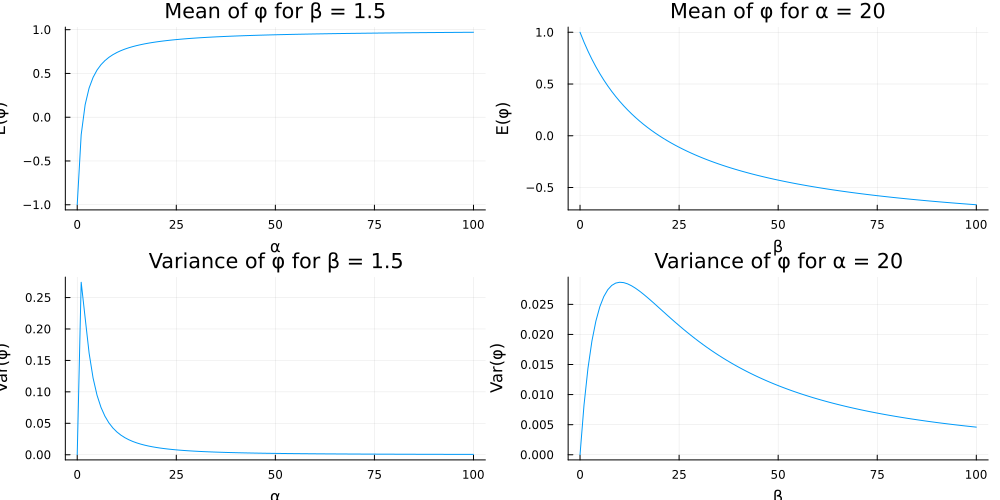

In [8]:
#Mean of φ for different values of α and β
alphas = 0:100 #Specify a range of alphas
betas = 0:100 #Specify a range of betas
means_phi_alphas = [mean_var_phi(i, beta)[1] for i in alphas] #Calculate means for all alphas and a fixed beta
vars_phi_alphas = [mean_var_phi(i, beta)[2] for i in alphas] #Calculate variances for all alphas and a fixed beta
means_phi_betas = [mean_var_phi(alpha, i)[1] for i in betas] #Calculate means for all alphas and a fixed beta
vars_phi_betas = [mean_var_phi(alpha,i )[2] for i in betas] #Calculate variances for all alphas and a fixed beta
plot_means_alphas = Plots.plot(alphas, means_phi_alphas, xlab = "α", ylab = "E(φ)", legend = false, title = "Mean of φ for β = $beta")
plot_means_betas = Plots.plot(betas, means_phi_betas, xlab = "β", ylab = "E(φ)", legend = false, title = "Mean of φ for α = $alpha")
plot_vars_alphas = Plots.plot(alphas, vars_phi_alphas, xlab = "α", ylab = "Var(φ)", legend = false, title = "Variance of φ for β = $beta")
plot_vars_betas = Plots.plot(betas, vars_phi_betas, xlab = "β", ylab = "Var(φ)", legend = false, title = "Variance of φ for α = $alpha")
Plots.plot(plot_means_alphas, plot_means_betas, plot_vars_alphas, plot_vars_betas, layout = 4, size = (1000, 500))


As the plots suggest, the $\alpha$ parameter seems to be a strong determinant of mean while the $\beta$ parameter has larger impact on variance. Lastly, we need to specify the prior for the volatility of log-variance. The choice of this parameter does not seem to have a large influence on the empirical results unless it is set too small. We can now proceed with the estimation.

In [41]:
#Estimation (2m)
MCD_log_ret_demeaned = MCD_log_ret .- Statistics.mean(MCD_log_ret) #Demeaning the log returns to avoid values very close to zero
RCall.R"""
set.seed(420) #Set seed for reproducibility
res <- svsample($MCD_log_ret_demeaned, priormu = c(-9, 1), priorphi = c(20, 1.5), priorsigma = 0.1, quiet = T)
vols <- vector("list", 3) #Empty vector to store the quantiles of the fitted volatilities
quants <- c(0.05, 0.5, 0.95) #Specify the quantiles
for (i in 1:3) { #Loop through the quantiles
    vols[[i]] <- apply(exp(res$latent[[1]]), 2, quantile, probs = quants[i]) #Store the given quantile of the exponentiated volatility
}
horizons <- c(1, 5, 22) #Specify the horizons
forecasts <- vector("list", 3) #Empty vector to store the forecasts
rets <- $MCD_log_ret_demeaned #Store the returns as an R variable
for (i in 1:3) { #Loop through the horizons
    res_hor <- svsample(rets[1:(length(rets) - horizons[i])], priormu = c(-9, 1), priorphi = c(20, 1.5), priorsigma = 0.1, quiet = T)
    forecasts[[i]] <- apply(as.matrix(predict(res_hor, horizons[i])[[1]][[1]]), 2, median) #Get the meadian of the predictions of returns
}
"""
preds = [RCall.convert(Array{Float64}, RCall.R"vols[[$i]]") for i in 1:3] #Convert the R list of fitted volatilities to a Julia array
forecasts = [RCall.convert(Array{Float64}, RCall.R"forecasts[[$i]]") for i in 1:3];  #Convert the R list of forecasts to a Julia array

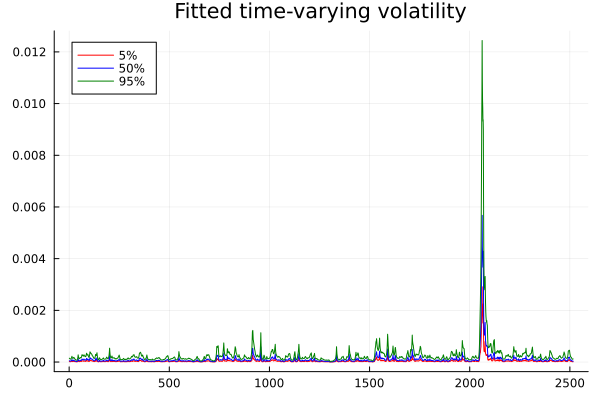

In [42]:
#Plot the fitted volatilities
Plots.plot(preds[1], label = "5%", title = "Fitted time-varying volatility", c = :red, legend = :topleft)
Plots.plot!(preds[2], c = :blue, label = "50%")
Plots.plot!(preds[3], c = :green, label = "95%")

Above we provide the 5th, 50th, and 90th quantile of the fitted volatility. For the sake of comparison of forecast performance, we also estimate a GARCH model (the optimal parameters for the underlying series were found in Project 1).

In [46]:
#Estimate GARCH
spec = ARCHModels.GARCH{1, 1}([0, .1, .08]) #Define the specifications and choose intial values for the coefficients
MCD_garch = ARCHModels.UnivariateARCHModel(spec, MCD_log_ret_demeaned; dist = ARCHModels.StdT(3.), meanspec = ARCHModels.AR{1}([0,-.1])) #Specify the model
ARCHModels.fit!(MCD_garch) #Fitting the model


GARCH{1, 1} model with Student's t errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate    Std.Error   z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000337663  0.000166505   2.02794    0.0426
φ₁  -0.0470443    0.0198131    -2.3744     0.0176
─────────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   6.39594e-6  2.97083e-6   2.15291    0.0313
β₁  0.854374    0.0516739   16.534      <1e-60
α₁  0.0908538   0.0305247    2.9764     0.0029
──────────────────────────────────────────────

Distribution parameters:
─────────────────────────────────────────
   Estimate  Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────
ν   4.21026   0.363055  11.5967    <1e-30
─────────────────────────────────────────


As can be seen, all the coefficients are statistically signifiant. We can now compare the fitted volatilities between the models.

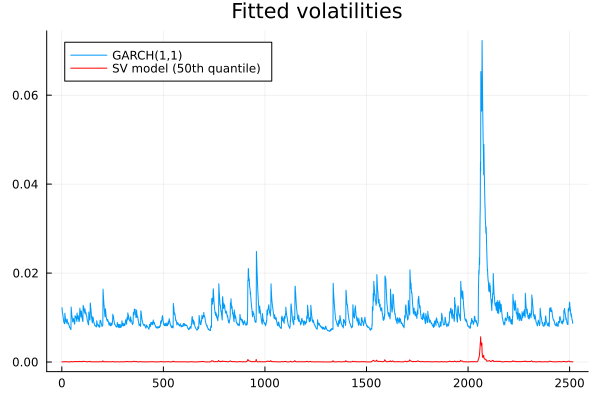

In [50]:
#Plot GARCH fitted volatility
Plots.plot(ARCHModels.volatilities(MCD_garch), title = "Fitted volatilities", label = "GARCH(1,1)", legend = :topleft)
Plots.plot!(preds[2], label = "SV model (50th quantile)", c =:red)

The stochastic volatility model appears to estimate volatility much lower in magnitude. We will see what will be the effect on the ability to predict returns. SInce we struggled to get the n-step ahead forecasts using the ``ARCHModels`` package in Julia, we perform the predicting using the R ``rugarch`` package instead.

In [ ]:
#GARCH forecasts
RCall.R"""
horizons <- c(1, 5, 22) #Specify the horizons
forecasts_garch <- vector("list", 3) #Empty vector for the forecasts
garchspec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), 
                        mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), distribution.model = "std") #Specification
log_rets <- $MCD_log_ret_demeaned #Store the log returns in R
for (i in 1:3) { #Loop through horizons
    garch_fit <- ugarchfit(garchspec, log_rets[1:(length(log_rets) - horizons[i])], solver = "hybrid") #Fit for each horizon
    forec <- ugarchforecast(garch_fit, n.ahead = horizons[i]) #Forecast
    forecasts_garch[[i]] <- as.numeric(fitted(forec)) #Store the forecasts
}
"""
forecasts_garch = [RCall.convert(Array{Float64}, RCall.R"forecasts_garch[[$i]]") for i in 1:3]; #Convert R list to Julia array

Now that we have the forecasts, we can calculate the MSE for each horizon and each model and compare them.

In [95]:
#Calculate MSEs
horizons = [1, 5, 22] #Specify the horizons
MSEs_stvol = zeros(3) #Empty vector for the MSEs of the stochastic volatility model
MSEs_garch = zeros(3) #Empty vector for the MSEs of the GARCH model
for i in 1:3 #Loop through horizons
    MSEs_stvol[i] = Statistics.mean((forecasts[i] .- MCD_log_ret_demeaned[(end - horizons[i] + 1):end]).^2) #Calculate the MSE for the given horizon
    MSEs_garch[i] = Statistics.mean((forecasts_garch[i] .- MCD_log_ret_demeaned[(end - horizons[i] + 1):end]).^2) #Calculate the MSE for the given horizon
end

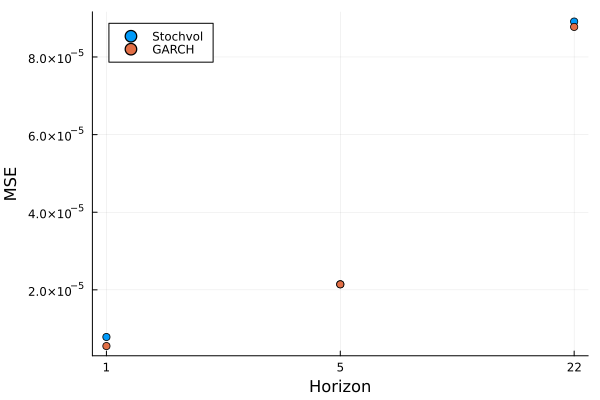

In [105]:
#Plot MSEs
Plots.plot(MSEs_stvol, seriestype = :scatter, legend = :topleft, label = "Stochvol", xlab = "Horizon", ylab = "MSE", xticks = ([1, 2, 3], horizons))
Plots.plot!(MSEs_garch, seriestype = :scatter, label = "GARCH")

As can be seen, GARCH appears to outperform the time-varying stochastic volatility model for the 1-step ahead and 22-steps ahead forecasts. The MSE for the 5-steps ahead scheme appears to virtually identical.

---
## Old code

In [286]:
#Calculating basic OLS parameters

test_size = 0
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size);
#WIP - lets first do simple OLS HAR on all the data
X_train_with_int = [ones((1, size(X_train)[2])); X_train] #Add ones for intercept estimation
inv(X_train_with_int * transpose(X_train_with_int)) * X_train_with_int * transpose(y_train) #Calculate the coefficients

4×1 Matrix{Float64}:
 9.82056424143176e-5
 0.03884726931711059
 0.17011491520317962
 0.4588606551734476

In [287]:
#now the function from Lectures - OLSestimatorconst
function OLSestimatorconst(y,x)
    x=[ones(size(x)[1]) x]
    return (transpose(x)*x) \ (transpose(x)*y)
end

OLSestimatorconst(target, predictors) #okk, we have working OLS HAR...now the Time variing part

4-element Vector{Float64}:
 9.820564033301494e-5
 0.03884727254180133
 0.17011492517697516
 0.45886064803361076

In [288]:
#now lets do the basic Rolling window OLS
window_size = 10
tv_parameters = zeros(size(predictors)[1]-window_size,size(predictors)[2] + 1) # plus one in the size for intercept

for i = 1:size(predictors)[1]-window_size #loop through one to end of data - window
    predictors_window = predictors[i:i+window_size-1, :] #always select subset for current window
    target_window = target[i:i+window_size-1]
    tv_parameters[i, :] = OLSestimatorconst(target_window, predictors_window) #make OLS estimate on it and save it
end
#size(tv_parameters)
#size(predictors)
#println(tv_parameters[1,:])
#println(tv_parameters[end,:])


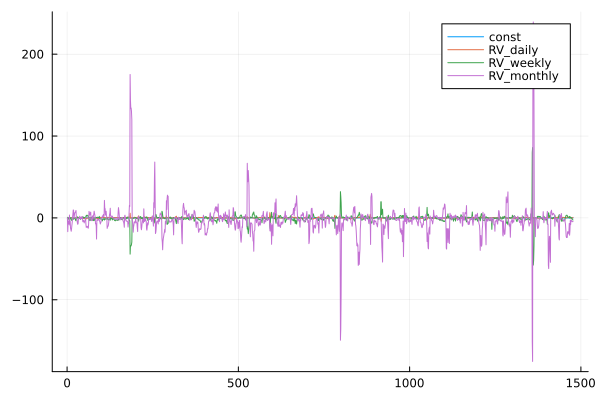

In [289]:
using Plots
plot([tv_parameters[:,1] tv_parameters[:,2] tv_parameters[:,3] tv_parameters[:,4]], label=["const" "RV_daily" "RV_weekly" "RV_monthly"])
#, tv_parameters[:,3], tv_parameters[:,4])

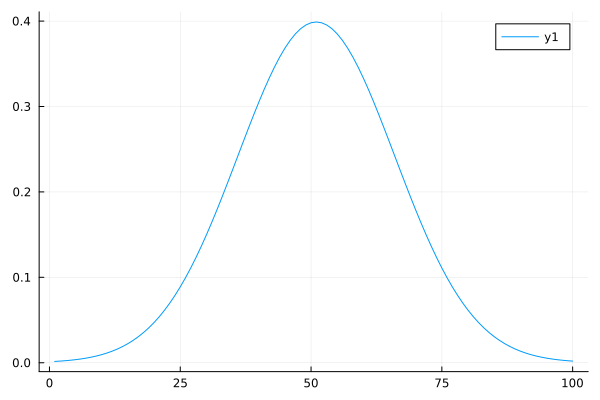

In [290]:
#Next TODO: make the poor mans version not so poor - add the kernel/smoothing
function Kernel(x,b)
    return (1/((sqrt(2*pi))))*exp(-0.5 *(x/b)^2)
end
#playing with Kernel
b=15
input = -50:49
kernel = zeros(length(1:100))
for i = 1:length(input)
    #kernel[i] = (1/((sqrt(2*pi))))*exp(-0.5 *(input[i]/b)^2)
    kernel[i] = Kernel(input[i], b)
end

plot(kernel)

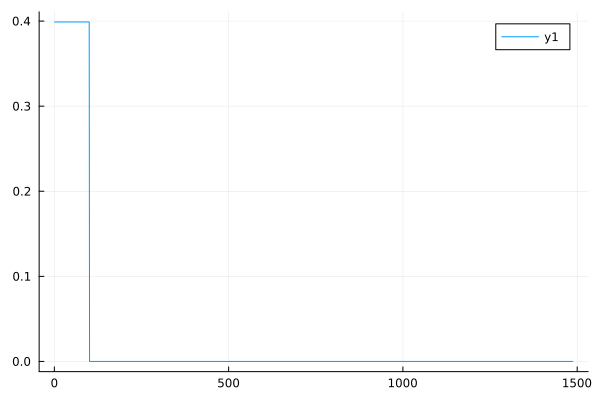

In [291]:
b=100
input = predictors[1:b, 1]
kernel = zeros(length(predictors[:, 1]))
for i = 1:length(input)
    #kernel[i] = (1/((sqrt(2*pi))))*exp(-0.5 *(input[i]/b)^2)
    kernel[i] = Kernel(input[i], b)
end

plot(predictors[1:b, 1]);
plot(kernel)

#I see, I will have to use the R package